In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pathlib import Path

import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

### Get the data

In [2]:
base_path = Path('/kaggle/input/wild-animals/Animals/')
paths = list(base_path.glob(r'*/*')) 


In [3]:
# paths
paths[0]

PosixPath('/kaggle/input/wild-animals/Animals/Cheetah/pexels-photo-4577569.jpeg')

In [4]:
FilePath = pd.Series(paths, name="FilePath").astype(str)
label = pd.Series([path.split("/")[5] for path in FilePath], name="Label").astype(str)


In [5]:
FilePath

0      /kaggle/input/wild-animals/Animals/Cheetah/pex...
1      /kaggle/input/wild-animals/Animals/Cheetah/pex...
2      /kaggle/input/wild-animals/Animals/Cheetah/pex...
3      /kaggle/input/wild-animals/Animals/Cheetah/che...
4      /kaggle/input/wild-animals/Animals/Cheetah/che...
                             ...                        
165    /kaggle/input/wild-animals/Animals/Leopard/pex...
166    /kaggle/input/wild-animals/Animals/Leopard/pex...
167    /kaggle/input/wild-animals/Animals/Leopard/pho...
168    /kaggle/input/wild-animals/Animals/Leopard/pex...
169    /kaggle/input/wild-animals/Animals/Leopard/pex...
Name: FilePath, Length: 170, dtype: object

In [6]:
df = pd.concat([FilePath, label], axis=1)

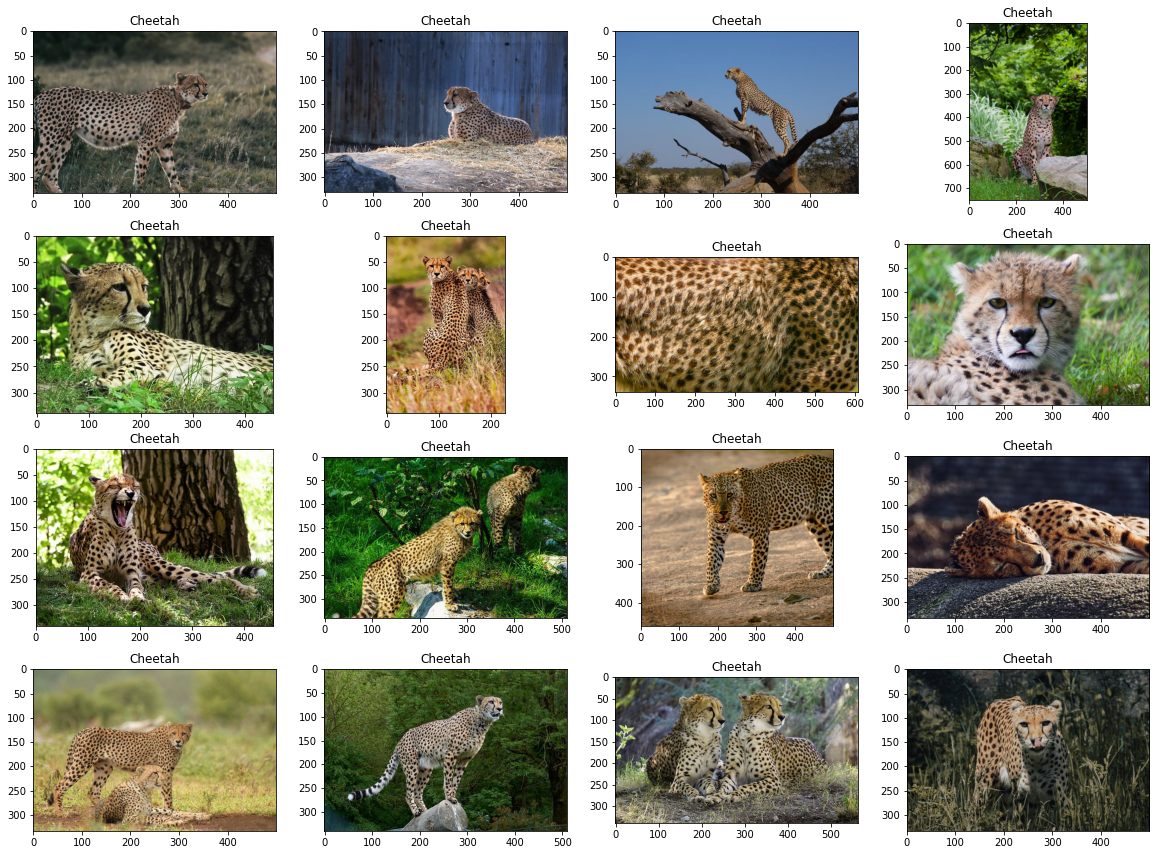

In [7]:
fig, ax = plt.subplots(4,4, figsize=(20,15))
for idx, axis in enumerate(ax.flat):
    _ = axis.imshow(plt.imread(df.FilePath[idx]))
    _ = axis.set_title(df.Label[idx])

Oh, we could see Cheetas, Jaguars and it looks good. Plotting the image always kind me gives us a sense of feeling that its real that we are going to do the classification, Yayy!

### Splitting the Data

In [8]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=0, shuffle=True)

In [9]:
print(len(train_df))
print(len(test_df))

136
34


It looks good. We can see that we do not have enough data so probably the model will overfit but let's look at how it performs.

### Generating the Data

In [10]:
train_generator = ImageDataGenerator(validation_split=0.2, rescale = 1./255 ) # Rescaling the data and splitting the training data in validation data as well
test_generator = ImageDataGenerator(rescale = 1./255) # Rescaling the data

In [11]:
train_imgs = train_generator.flow_from_dataframe(
    dataframe = train_df,
    x_col = "FilePath",
    y_col = "Label",
    target_size = (224, 224),
    color_mode = "rgb",
    class_mode = "categorical",
    batch_size = 32,
    shuffle = True,
    subset = "training"
)
val_imgs = train_generator.flow_from_dataframe(
    dataframe = train_df,
    x_col = "FilePath",
    y_col = "Label",
    target_size = (224, 224),
    color_mode = "rgb",
    class_mode = "categorical",
    batch_size = 32,
    shuffle = True,
    subset = "validation"
)

test_imgs = test_generator.flow_from_dataframe(
    dataframe = test_df,
    x_col = "FilePath",
    y_col = "Label",
    target_size = (224, 224),
    color_mode = "rgb",
    class_mode = "categorical",
    batch_size = 32,
    shuffle = False
)

Found 109 validated image filenames belonging to 5 classes.
Found 27 validated image filenames belonging to 5 classes.
Found 34 validated image filenames belonging to 5 classes.


Okie Dokie, ImageDataGenerator have successfully recognised the classes and yes there are total of 5 classes.

### Model Creation

In [12]:

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), padding="Same", activation="relu", input_shape=(224, 224, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), padding="Same", activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), padding="Same", activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), padding="Same", activation='relu'),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(5, activation='softmax'),
])
model.compile(
    optimizer='rmsprop',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 28, 28, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 128)       7

In [13]:
history = model.fit(train_imgs, batch_size = 32, validation_data=val_imgs, epochs=5)

Epoch 1/5
4/4 [==============================] - 8s 2s/step - loss: 3.1181 - accuracy: 0.1681 - val_loss: 1.5991 - val_accuracy: 0.2222
Epoch 2/5
4/4 [==============================] - 6s 2s/step - loss: 1.6146 - accuracy: 0.2696 - val_loss: 1.6127 - val_accuracy: 0.2222
Epoch 3/5
4/4 [==============================] - 6s 1s/step - loss: 1.6024 - accuracy: 0.2543 - val_loss: 2.0295 - val_accuracy: 0.2222
Epoch 4/5
4/4 [==============================] - 6s 2s/step - loss: 1.7810 - accuracy: 0.2534 - val_loss: 1.5997 - val_accuracy: 0.2222
Epoch 5/5
4/4 [==============================] - 6s 2s/step - loss: 1.5972 - accuracy: 0.2641 - val_loss: 1.6193 - val_accuracy: 0.2222


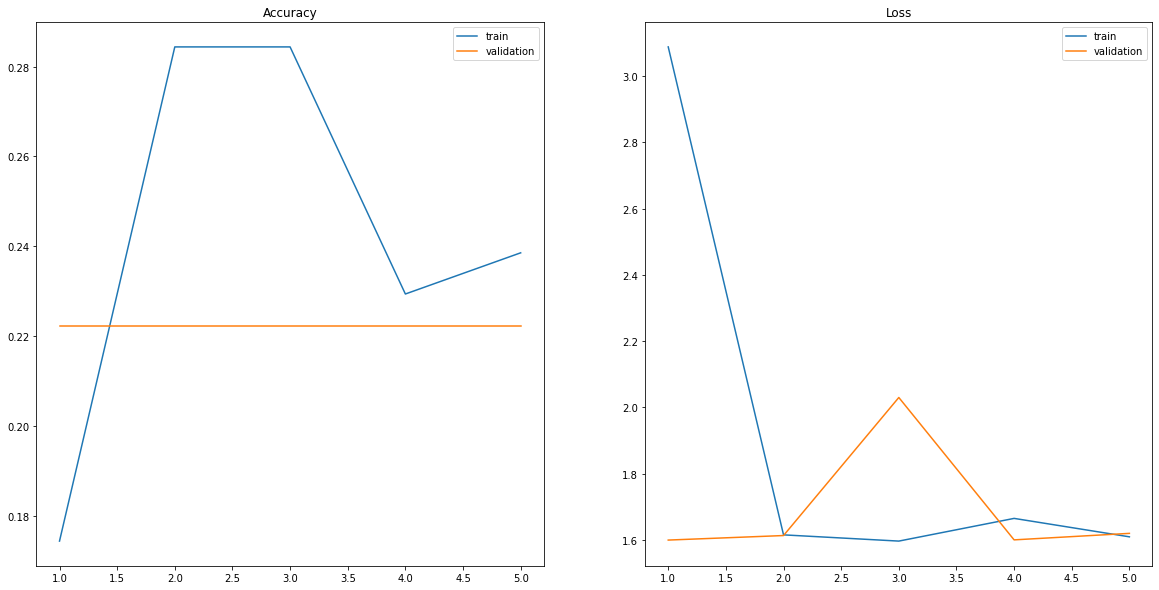

In [14]:
train_accuracy =  history.history['accuracy']
train_loss =  history.history['loss']

val_accuracy =  history.history['val_accuracy']
val_loss =  history.history['val_loss']
epochs = range(1, len(train_accuracy) + 1)

figure, axis = plt.subplots(1, 2, figsize=(20, 10))
axis[0].plot(epochs, train_accuracy, label="train")
axis[0].plot(epochs, val_accuracy, label="validation")
axis[0].set_title('Accuracy')
axis[0].legend()
axis[1].plot(epochs, train_loss, label="train")
axis[1].plot(epochs, val_loss, label="validation")
axis[1].set_title('Loss')
axis[1].legend()

plt.show()

In [15]:
pred = model.predict(test_imgs)

In [16]:
output = np.argmax(pred, axis=1)

In [17]:
labels = test_imgs.class_indices # Will get the indices of the classes in integer

In [18]:
y_vals = []
pred_labels = dict((v, k) for k, v in labels.items()) # mapping the classes with the indices

for i in range(0, len(output)):
    y_vals.append(pred_labels[output[i]])

In [19]:
print(classification_report(test_df.Label, y_vals))
print(confusion_matrix(test_df.Label, y_vals))

              precision    recall  f1-score   support

     Cheetah       0.00      0.00      0.00         8
      Jaguar       0.00      0.00      0.00         5
     Leopard       0.00      0.00      0.00         6
        Lion       0.00      0.00      0.00         9
       Tiger       0.18      1.00      0.30         6

    accuracy                           0.18        34
   macro avg       0.04      0.20      0.06        34
weighted avg       0.03      0.18      0.05        34

[[0 0 0 0 8]
 [0 0 0 0 5]
 [0 0 0 0 6]
 [0 0 0 0 9]
 [0 0 0 0 6]]


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


We could see that for Lion and for Leopard, it is not able to recognise!